Quite messy notebook using mix of several lightgmb models predictions.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import random

from tqdm.notebook import tqdm

from functools import partial
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(seed=0)

In [3]:
train = False

In [4]:
weights_lambda = 0.90 # reflect the weight decay for distant days

In [5]:
print([weights_lambda ** i for i in range(100)])

[1.0, 0.9, 0.81, 0.7290000000000001, 0.6561, 0.5904900000000001, 0.531441, 0.4782969000000001, 0.4304672100000001, 0.3874204890000001, 0.3486784401000001, 0.31381059609000006, 0.2824295364810001, 0.2541865828329001, 0.2287679245496101, 0.20589113209464907, 0.18530201888518416, 0.16677181699666577, 0.15009463529699918, 0.13508517176729928, 0.12157665459056935, 0.10941898913151242, 0.09847709021836118, 0.08862938119652507, 0.07976644307687256, 0.0717897987691853, 0.06461081889226677, 0.058149737003040096, 0.05233476330273609, 0.047101286972462485, 0.04239115827521624, 0.038152042447694615, 0.03433683820292515, 0.030903154382632636, 0.027812838944369374, 0.025031555049932437, 0.022528399544939195, 0.020275559590445275, 0.01824800363140075, 0.016423203268260675, 0.014780882941434608, 0.013302794647291146, 0.011972515182562033, 0.01077526366430583, 0.009697737297875247, 0.008727963568087723, 0.00785516721127895, 0.007069650490151055, 0.00636268544113595, 0.005726416897022355, 0.005153775207

# Preparing data

In [6]:
train_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/train.csv')
train_df = train_df.fillna('')
train_df.tail()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
754929,969574,,,Zimbabwe,14240168,0.607106,2020-05-08,Fatalities,0.0
754930,969575,,,Zimbabwe,14240168,0.060711,2020-05-09,ConfirmedCases,1.0
754931,969576,,,Zimbabwe,14240168,0.607106,2020-05-09,Fatalities,0.0
754932,969577,,,Zimbabwe,14240168,0.060711,2020-05-10,ConfirmedCases,1.0
754933,969578,,,Zimbabwe,14240168,0.607106,2020-05-10,Fatalities,0.0


In [7]:
test_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/test.csv')
test_df = test_df.fillna('')
test_df.tail()

,ForecastId,County,Province_State,Country_Region,Population,Weight,Date,Target
311665,311666,,,Zimbabwe,14240168,0.607106,2020-06-08,Fatalities
311666,311667,,,Zimbabwe,14240168,0.060711,2020-06-09,ConfirmedCases
311667,311668,,,Zimbabwe,14240168,0.607106,2020-06-09,Fatalities
311668,311669,,,Zimbabwe,14240168,0.060711,2020-06-10,ConfirmedCases
311669,311670,,,Zimbabwe,14240168,0.607106,2020-06-10,Fatalities


In [8]:
num_dates_total = len(np.unique(list(train_df['Date']) + list(test_df['Date'])))
print(num_dates_total)
num_dates_test = len(np.unique(list(test_df['Date'])))
print(num_dates_test)
num_dates_train = len(np.unique(list(train_df['Date'])))
print(num_dates_train)

140
45
109


In [9]:
sample_submission = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/submission.csv')
sample_submission.head()

,ForecastId_Quantile,TargetValue
0,1_0.05,1
1,1_0.5,1
2,1_0.95,1
3,2_0.05,1
4,2_0.5,1


In [10]:
len(sample_submission) / 3

311670.0

# EDA

In [11]:
cases = train_df["TargetValue"][train_df["Target"] == 'ConfirmedCases'].values.reshape((-1, num_dates_train))
cases

array([[  0.,   0.,   0., ..., 215., 255., 369.],
       [  0.,   0.,   0., ...,   8.,   6.,  12.],
       [  0.,   0.,   0., ..., 187., 189., 165.],
       ...,
       [  0.,   0.,   0., ...,   9.,   0.,  17.],
       [  0.,   0.,   0., ...,  14.,  85.,  15.],
       [  0.,   0.,   0., ...,   0.,   1.,   1.]])

In [12]:
fatalities = train_df["TargetValue"][train_df["Target"] == 'Fatalities'].values.reshape((-1, num_dates_train))
fatalities

array([[0., 0., 0., ..., 3., 6., 5.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 5., 6., 8.],
       ...,
       [0., 0., 0., ..., 2., 0., 1.],
       [0., 0., 0., ..., 0., 3., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
#making the weights equal
fatalities = fatalities * 10

In [14]:
population = train_df["Population"].values[::num_dates_train * 2]
population
len(population)

3463

In [15]:
weignts_cases = train_df["Weight"][train_df["Target"] == 'ConfirmedCases'].values[::num_dates_train]
weignts_cases
len(weignts_cases)

3463

In [16]:
import lightgbm as lgbm
f = lgbm.LGBMRegressor()

In [17]:
if train:
    days_to_predict = 45
else:
    days_to_predict = 31
train_days_used = num_dates_total - days_to_predict
assert train_days_used <= num_dates_train


features_days = 40
test_days_predict = 40
train_data = []
target_data = []
test_data = []
weights = []


fat_index_add = features_days
fat_index_add_test = test_days_predict 

In [18]:
for i in range(len(population)):
    for j in range(train_days_used - 1 - features_days):
        full_train = True
        
        data = []
        data = data + [population[i]]
        max_cases = cases[i][:j+features_days].max()
        data = data + [max_cases]
        max_fatalities = fatalities[i][:j+features_days].max()
        data = data + [max_fatalities]
        data = data + list(cases[i][j:j+features_days]/(max_cases+1))
        data = data + list(fatalities[i][j:j+features_days]/(max_fatalities+1))
        train_data.append(data)

        target = []
        target_list = list(cases[i][j+features_days:j+features_days + test_days_predict]/(max_cases+1))
        target_list = target_list + [None]*(test_days_predict - len(target_list))
        target = target + target_list

        target_list = list(fatalities[i][j+features_days:j+features_days + test_days_predict]/(max_fatalities+1))
        target_list = target_list + [None]*(test_days_predict - len(target_list))
        target = target + target_list           

        target_data.append(target)
        weights.append(weignts_cases[i]*weights_lambda**(train_days_used - test_days_predict - features_days - j - 1))
    
    test = []
    test = test + [population[i]]
    max_cases = cases[i][:train_days_used].max()
    test = test + [max_cases]
    max_fatalities = fatalities[i][:train_days_used].max()
    test = test + [max_fatalities]
    test = test + list(cases[i][train_days_used - features_days:train_days_used]/(max_cases+1))
    test = test + list(fatalities[i][train_days_used - features_days:train_days_used]/(max_fatalities+1))
    test_data.append(test)        

initial_train_data = np.stack(train_data)
target_data = np.stack(target_data)
max_features_days = features_days
max_test_days_predict = test_days_predict
initial_test_data = np.stack(test_data)
weights = np.array(weights)    

In [19]:
i = 0
test = []
test = test + [population[i]]
max_cases = cases[i][:train_days_used].max()
test = test + [max_cases]
max_fatalities = fatalities[i][:train_days_used].max()
test = test + [max_fatalities]
test = test + list(cases[i][train_days_used - features_days:train_days_used]/(max_cases+1))
test = test + list(fatalities[i][train_days_used - features_days:train_days_used]/(max_fatalities+1))
test_data.append(test)   

In [20]:
predictions_cases_global = []
predictions_cases_max_global = np.zeros((len(population), days_to_predict))
predictions_cases_min_global = np.zeros((len(population), days_to_predict)) + 1000000

predictions_fatalities_global = []
predictions_fatalities_max_global = np.zeros((len(population), days_to_predict))
predictions_fatalities_min_global = np.zeros((len(population), days_to_predict)) + 1000000

In [21]:
for features_days in tqdm(range(5, 40, 5)):
    fat_index_add = features_days
    train_data = np.concatenate([initial_train_data[:,:3], 
                                 initial_train_data[:,3+max_features_days-features_days:3+max_features_days],
                                 initial_train_data[:,3+2*max_features_days-features_days:3+2*max_features_days],
                                ], axis = 1).copy()
    
    case_predictors = []
    for i in range(max_test_days_predict):
        f = lgbm.LGBMRegressor()
        mask = np.logical_not(pd.isnull(target_data[:,i]))
        f.fit(train_data[mask], target_data[:,i][mask],sample_weight = weights[mask], verbose=False)
        case_predictors.append(f)

    fatalities_predictors = []
    for i in range(max_test_days_predict):
        f = lgbm.LGBMRegressor()
        mask = np.logical_not(pd.isnull(target_data[:,max_test_days_predict + i]))
        f.fit(train_data[mask], target_data[:,max_test_days_predict + i][mask],sample_weight = weights[mask], verbose=False)
        fatalities_predictors.append(f)
        
    
    for test_days_predict in range(1,32, 3):
        
        test_data = np.concatenate([initial_test_data[:,:3], 
                             initial_test_data[:,3+max_features_days-features_days:3+max_features_days],
                             initial_test_data[:,3+2*max_features_days-features_days:3+2*max_features_days],
                            ], axis = 1).copy()
        
        predictions_cases_sum = np.zeros((len(population), days_to_predict))
        predictions_cases_max = np.zeros((len(population), days_to_predict))
        predictions_cases_min= np.zeros((len(population), days_to_predict))+ 1000000
        predictions_cases_counts = np.zeros(days_to_predict)


        predictions_fatalities_sum = np.zeros((len(population), days_to_predict))
        predictions_fatalities_max = np.zeros((len(population), days_to_predict))
        predictions_fatalities_min= np.zeros((len(population), days_to_predict))+ 1000000
        predictions_fatalities_counts = np.zeros(days_to_predict)

        for step in range(days_to_predict - test_days_predict + 1):
            predictions_cases_local = np.zeros((len(population), test_days_predict))
            predictions_fatalities_local = np.zeros((len(population), test_days_predict))

            for i in range(test_days_predict):
                predictions_cases_local[:,i] = case_predictors[i].predict(test_data) * (test_data[:,1] + 1)

            for i in range(test_days_predict):
                predictions_fatalities_local[:,i] = fatalities_predictors[i].predict(test_data) * (test_data[:,2] + 1)


            predictions_cases_sum[:,step:step+test_days_predict] += predictions_cases_local
            predictions_cases_max[:,step:step+test_days_predict] = np.maximum(predictions_cases_max[:,step:step+test_days_predict], predictions_cases_local)
            predictions_cases_min[:,step:step+test_days_predict] = np.minimum(predictions_cases_min[:,step:step+test_days_predict], predictions_cases_local)
            predictions_cases_counts[step:step+test_days_predict] += 1

            current_predictions_cases = predictions_cases_sum[:,step] / predictions_cases_counts[step]


            predictions_fatalities_sum[:,step:step+test_days_predict] += predictions_fatalities_local
            predictions_fatalities_max[:,step:step+test_days_predict] = np.maximum(predictions_fatalities_max[:,step:step+test_days_predict], predictions_fatalities_local)
            predictions_fatalities_min[:,step:step+test_days_predict] = np.minimum(predictions_fatalities_min[:,step:step+test_days_predict], predictions_fatalities_local)
            predictions_fatalities_counts[step:step+test_days_predict] += 1

            current_predictions_fatalities = predictions_fatalities_sum[:,step] / predictions_fatalities_counts[step]

            test_data[:,3:3+features_days-1] = test_data[:,4:3+features_days]
            new_max = np.maximum(test_data[:,1], current_predictions_cases)
            test_data[:,3:3+features_days -1] *= ((test_data[:,1] + 1) / (new_max + 1)).reshape((-1,1))
            test_data[:,2+features_days] = current_predictions_cases / (new_max+1)
            test_data[:,1] = new_max



            test_data[:,3+features_days:3+features_days-1+features_days] = test_data[:,4+features_days:3+features_days+features_days]
            new_max = np.maximum(test_data[:,2], current_predictions_fatalities)
            test_data[:,3+features_days:3+features_days+features_days-1] *= ((test_data[:,2] + 1) /(new_max + 1) ).reshape((-1,1))
            test_data[:,2+features_days+features_days] = current_predictions_fatalities / (new_max+1)
            test_data[:,2] = new_max


        predictions_cases_global.append(predictions_cases_sum / predictions_cases_counts)
        predictions_cases_min_global = np.minimum(predictions_cases_min_global, predictions_cases_min)
        predictions_cases_max_global = np.maximum(predictions_cases_max_global, predictions_cases_max)

        predictions_fatalities_global.append(predictions_fatalities_sum / predictions_fatalities_counts)
        predictions_fatalities_min_global = np.minimum(predictions_fatalities_min_global, predictions_fatalities_min)
        predictions_fatalities_max_global = np.maximum(predictions_fatalities_max_global, predictions_fatalities_max)


In [22]:
final_predictions_cases = np.stack(predictions_cases_global).mean(0)
final_predictions_fatalities = np.stack(predictions_fatalities_global).mean(0)

In [23]:
final_predictions_cases_std = np.stack(predictions_cases_global).std(0)
final_predictions_fatalities_std = np.stack(predictions_fatalities_global).std(0)

# Making simple submission and valiadtion

In [24]:
valid_len = num_dates_train + days_to_predict - num_dates_total
valid_len

0

In [25]:
valid_true_cases = cases[:,-valid_len:]
valid_true_fatalities = fatalities[:, -valid_len:]

In [26]:
predict_mean_cases = final_predictions_cases[:,:valid_len].copy()
predict_min_cases = predictions_cases_min_global[:,:valid_len].copy()
predict_max_cases = predictions_cases_max_global[:,:valid_len].copy()

predict_mean_fatalities = final_predictions_fatalities[:,:valid_len].copy()
predict_min_fatalities = predictions_fatalities_min_global[:,:valid_len].copy()
predict_max_fatalities = predictions_fatalities_max_global[:,:valid_len].copy()

In [27]:
def compute_loss_L(true_array, predicted_array, tau, weight):
    array = predicted_array * (predicted_array > 0)
    abs_diff = np.absolute(true_array - array)
    result = abs_diff * (1 -tau) * (array > true_array) + abs_diff * (tau) * (array <= true_array)
    result = (result.mean(1)) * weight
#     print(result.mean())
    return result.mean()

In [28]:
def compute_loss(true_array, mean_array, min_array, max_array, weights):
    result = (compute_loss_L(true_array, max_array, 0.95, weights) + 
              compute_loss_L(true_array, min_array, 0.05, weights) + 
              compute_loss_L(true_array, mean_array, 0.5, weights))
    return result / 3

In [29]:
x0 = [1,0,0,0]

def normalize(x, mean_array, min_array, max_array, base = None):
    if base is None:
        base = np.zeros_like(mean_array)
        lamb = 0
    else:
        lamb = x[3]
    deviation = np.array([lamb * n for n in range(base.shape[1])])
    new_array = base + (x[0] * mean_array + x[1] * min_array + x[2]*max_array) * (deviation + 1).reshape((1,-1))
#     print(deviation)
    return new_array

In [30]:
def fun(x, mean_array, min_array, max_array, true_array, weights, tau, base = None):
    new_array = normalize(x, mean_array, min_array, max_array, base = base)
    return compute_loss_L(true_array, new_array, tau, weights)

In [31]:
from scipy.optimize import minimize
from functools import partial

In [32]:
x = [ 1.05220987e+00,  1.99235423e-02, -1.52479300e-01,  0]
if train:
    part_func = partial(fun, mean_array = predict_mean_cases, min_array = predict_min_cases, max_array = predict_max_cases, weights = weignts_cases, tau = 0.5, true_array = valid_true_cases)
    res = minimize(part_func, x0 = [1,0,0,0], method='Powell', tol=1e-6)
    print(res.fun)
    print(res.x)
    x = res.x

new_final_predictions_cases = normalize(x, final_predictions_cases, predictions_cases_min_global, predictions_cases_max_global)


x = [-0.57039983,  0.53805868, -0.29206055, -0.02496633]
if train:
    part_func = partial(fun, mean_array = predict_mean_cases, min_array = predict_min_cases, max_array = predict_max_cases, weights = weignts_cases, tau = 0.05, true_array = valid_true_cases, 
                        base = new_final_predictions_cases[:,:valid_len])
    res = minimize(part_func, x0 = [1,0,0, 0], method='Powell', tol=1e-6)
    print(res.fun)
    print(res.x)
    x = res.x

new_predictions_cases_min_global = normalize(x, final_predictions_cases, predictions_cases_min_global, predictions_cases_max_global, base = new_final_predictions_cases)


x = [0.68391658, -0.12920086,  0.1162962,   0.00088057]
if train:
    part_func = partial(fun, mean_array = predict_mean_cases, min_array = predict_min_cases, max_array = predict_max_cases, weights = weignts_cases, tau = 0.95, true_array = valid_true_cases,
                       base = new_final_predictions_cases[:,:valid_len])
    res = minimize(part_func, x0 = [1,0,0, 0], method='Powell', tol=1e-6)
    print(res.fun)
    print(res.x)
    x = res.x

new_predictions_cases_max_global = normalize(x, final_predictions_cases, predictions_cases_min_global, predictions_cases_max_global, base = new_final_predictions_cases)

final_predictions_cases = new_final_predictions_cases
predictions_cases_min_global = new_predictions_cases_min_global
predictions_cases_max_global = new_predictions_cases_max_global

In [33]:
x = [ 0.62488135,  0.30215376, -0.10868626,  0]
if train:
    part_func = partial(fun, mean_array = predict_mean_fatalities, min_array = predict_min_fatalities, max_array = predict_max_fatalities, weights = weignts_cases, 
                        tau = 0.5, true_array = valid_true_fatalities)
    res = minimize(part_func, x0 = [1,0,0, 0], method='Powell', tol=1e-6)
    print(res.fun)
    print(res.x)
    x = res.x

new_final_predictions_fatalities = normalize(x, final_predictions_fatalities, predictions_fatalities_min_global, predictions_fatalities_max_global)


x = [-0.91401564,  0.79599391, -0.22610482, -0.03988415]
if train:
    part_func = partial(fun, mean_array = predict_mean_fatalities, min_array = predict_min_fatalities, max_array = predict_max_fatalities, weights = weignts_cases, 
                        tau = 0.05,
                        true_array = valid_true_fatalities, base = new_final_predictions_fatalities[:,:valid_len])
    res = minimize(part_func, x0 = [1,0,0, 0], method='Powell', tol=1e-6)
    print(res.fun)
    print(res.x)
    x = res.x

new_predictions_fatalities_min_global = normalize(x, final_predictions_fatalities, predictions_fatalities_min_global, predictions_fatalities_max_global,
                                                  base = new_final_predictions_fatalities)


x = [0.87657726, -0.021317,   -0.04123832,  0.02195802]
if train:
    part_func = partial(fun, mean_array = predict_mean_fatalities, min_array = predict_min_fatalities, max_array = predict_max_fatalities, weights = weignts_cases, 
                        tau = 0.95, 
                        true_array = valid_true_fatalities, base = new_final_predictions_fatalities[:,:valid_len])
    res = minimize(part_func, x0 = [1,0,0, 0], method='Powell', tol=1e-6)
    print(res.fun)
    print(res.x)
    x = res.x

new_predictions_fatalities_max_global = normalize(x, final_predictions_fatalities, predictions_fatalities_min_global, predictions_fatalities_max_global,
                                                  base = new_final_predictions_fatalities)

final_predictions_fatalities = new_final_predictions_fatalities
predictions_fatalities_min_global = new_predictions_fatalities_min_global
predictions_fatalities_max_global = new_predictions_fatalities_max_global

In [34]:
predict_mean_cases = final_predictions_cases[:,:valid_len].copy()
predict_min_cases = predictions_cases_min_global[:,:valid_len].copy()
predict_max_cases = predictions_cases_max_global[:,:valid_len].copy()

predict_mean_fatalities = final_predictions_fatalities[:,:valid_len].copy()
predict_min_fatalities = predictions_fatalities_min_global[:,:valid_len].copy()
predict_max_fatalities = predictions_fatalities_max_global[:,:valid_len].copy()

In [35]:
if train:
    total_loss = (compute_loss(valid_true_cases, predict_mean_cases, predict_min_cases, 
                                   predict_max_cases , weignts_cases) + 
                     compute_loss(valid_true_fatalities, predict_mean_fatalities, predict_min_fatalities, 
                                  predict_max_fatalities, weignts_cases)) / 2

    print(total_loss)

# Making prediction file

In [36]:
submission_mean_cases = np.zeros((len(population), 45))
submission_min_cases = np.zeros((len(population), 45))
submission_max_cases = np.zeros((len(population), 45))

submission_mean_fatalities = np.zeros((len(population), 45))
submission_min_fatalities = np.zeros((len(population), 45))
submission_max_fatalities = np.zeros((len(population), 45))

In [37]:
submission_mean_cases[:, -days_to_predict:] = final_predictions_cases
submission_min_cases[:, -days_to_predict:] = predictions_cases_min_global
submission_max_cases[:, -days_to_predict:] = predictions_cases_max_global


submission_mean_fatalities[:, -days_to_predict:] = final_predictions_fatalities / 10
submission_min_fatalities[:, -days_to_predict:] = predictions_fatalities_min_global / 10
submission_max_fatalities[:, -days_to_predict:] = predictions_fatalities_max_global / 10

In [38]:
submission_mean_cases[:, :-days_to_predict] = cases[:, num_dates_total-45:num_dates_total-days_to_predict]
submission_min_cases[:, :-days_to_predict] = cases[:, num_dates_total-45:num_dates_total-days_to_predict]
submission_max_cases[:, :-days_to_predict] = cases[:, num_dates_total-45:num_dates_total-days_to_predict]


submission_mean_fatalities[:, :-days_to_predict] = fatalities[:, num_dates_total-45:num_dates_total-days_to_predict] / 10
submission_min_fatalities[:, :-days_to_predict] = fatalities[:, num_dates_total-45:num_dates_total-days_to_predict] / 10
submission_max_fatalities[:, :-days_to_predict] = fatalities[:, num_dates_total-45:num_dates_total-days_to_predict] / 10 

In [39]:
loss_1 = compute_loss(fatalities[:,-14:] / 10, submission_mean_fatalities[:,:14] , submission_min_fatalities[:,:14], 
                                   submission_max_fatalities[:,:14],weignts_cases * 10)

In [40]:
loss_2 = compute_loss(cases[:,-14:], submission_mean_cases[:,:14] , submission_min_cases[:,:14], 
                                   submission_max_cases[:,:14],weignts_cases)

In [41]:
loss_1

0.0028810822971369957

In [42]:
loss_2

0.005331406351377493

In [43]:
(loss_1 + loss_2) / 2

0.0041062443242572445

In [44]:
#0.25734741800417726

In [45]:
submission_file = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-5/submission.csv')

In [46]:
submission_file

,ForecastId_Quantile,TargetValue
0,1_0.05,1
1,1_0.5,1
2,1_0.95,1
3,2_0.05,1
4,2_0.5,1
...,...,...
935005,311669_0.5,1
935006,311669_0.95,1
935007,311670_0.05,1
935008,311670_0.5,1


In [47]:
submission = []
for i in range(len(submission_mean_cases)):
    for j in range(len(submission_mean_cases[0])):
        submission.append(submission_min_cases[i][j])
        submission.append(submission_mean_cases[i][j])
        submission.append(submission_max_cases[i][j])
        
        submission.append(submission_min_fatalities[i][j])
        submission.append(submission_mean_fatalities[i][j])
        submission.append(submission_max_fatalities[i][j])

In [48]:
submission = [max(0,x) for x in submission]

In [49]:
submission_file['TargetValue'] = submission

In [50]:
submission_file.to_csv('submission.csv', index = False)

In [51]:
submission_file

,ForecastId_Quantile,TargetValue
0,1_0.05,172.000000
1,1_0.5,172.000000
2,1_0.95,172.000000
3,2_0.05,7.000000
4,2_0.5,7.000000
...,...,...
935005,311669_0.5,1.999572
935006,311669_0.95,8.692003
935007,311670_0.05,0.000000
935008,311670_0.5,0.000000


# Visualisation of predictions

In [52]:
import matplotlib.pyplot as plt
def plot_results(true_array, mean_array, max_array, min_array):
    nans = np.array([None]*len(true_array))
    plt.plot(true_array)
    plt.plot(np.concatenate([nans,mean_array[-days_to_predict:]]))
    plt.plot(np.concatenate([nans,min_array[-days_to_predict:]]))
    plt.plot(np.concatenate([nans,max_array[-days_to_predict:]]))
    
    plt.show()

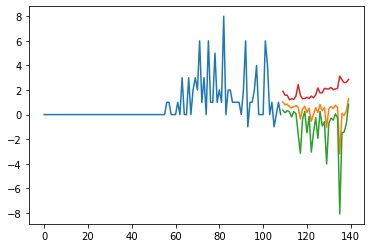

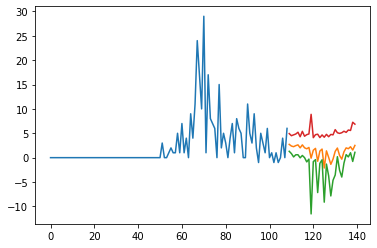

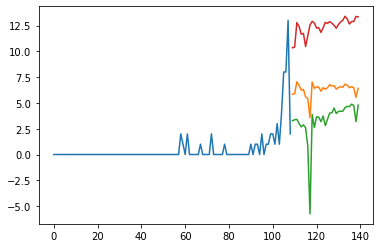

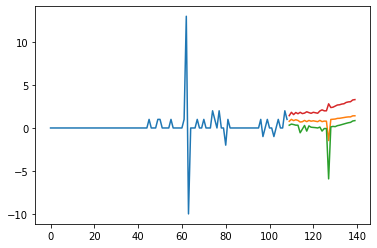

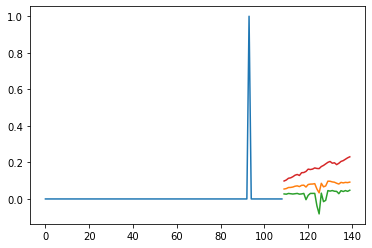

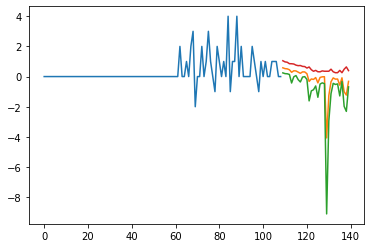

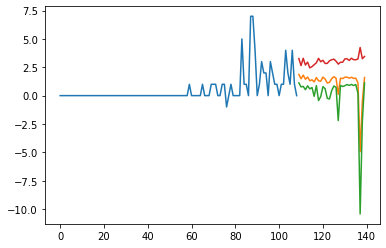

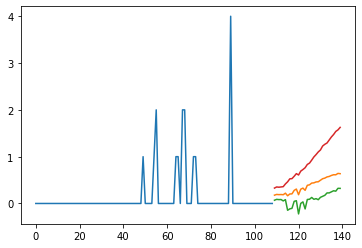

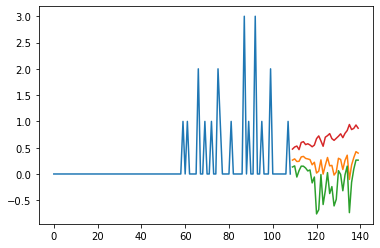

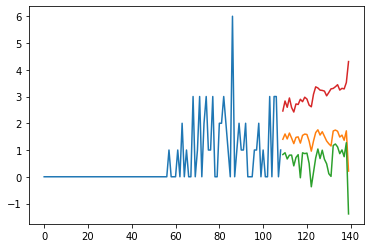

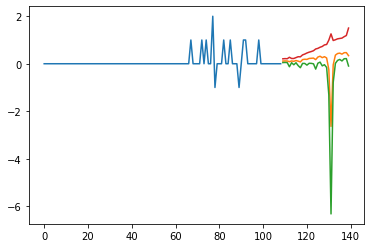

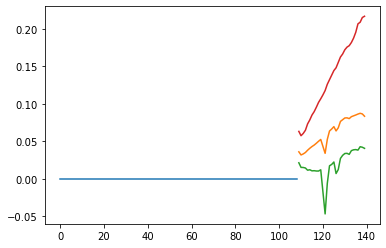

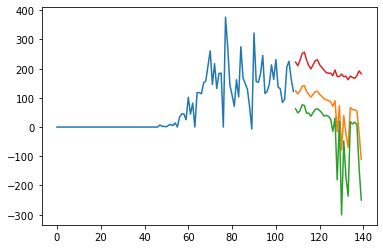

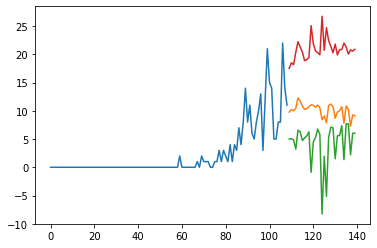

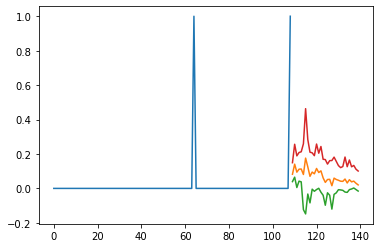

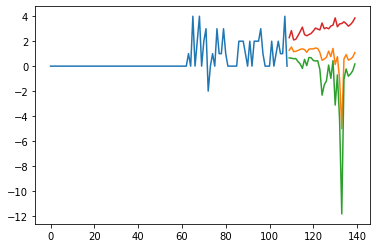

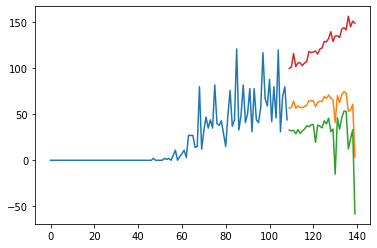

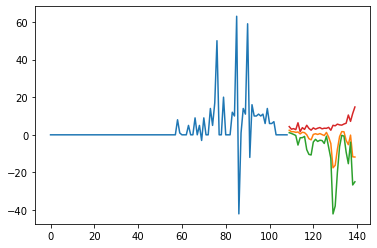

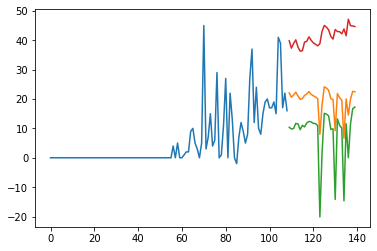

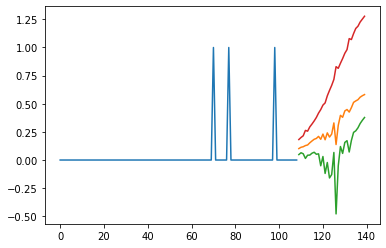

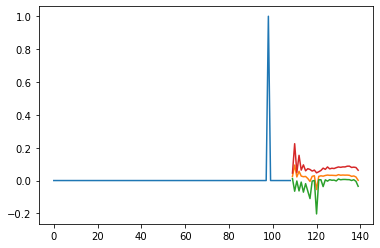

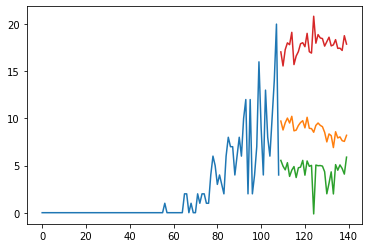

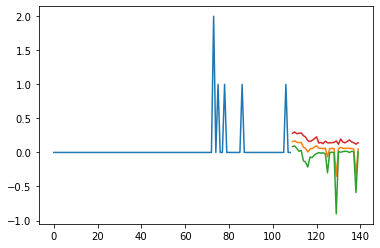

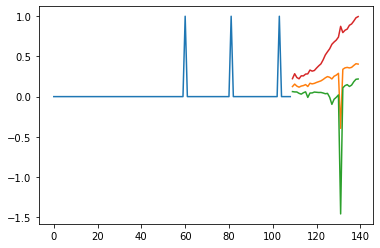

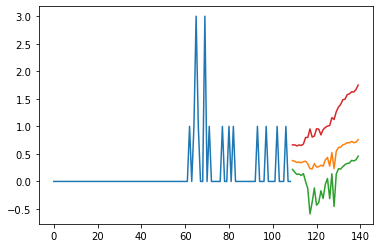

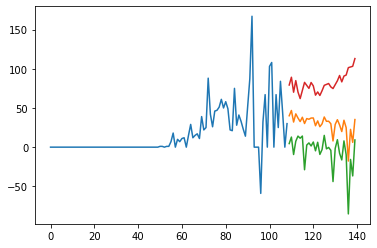

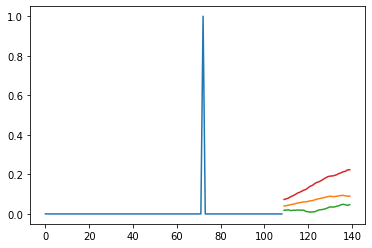

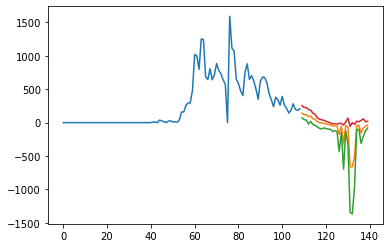

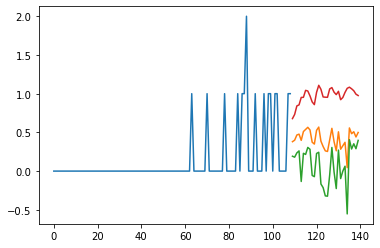

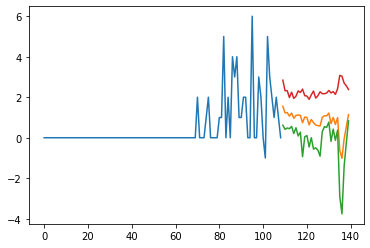

In [53]:
for i in np.random.randint(0, len(cases),30):
    plot_results(cases[i], submission_mean_cases[i], submission_max_cases[i], submission_min_cases[i])

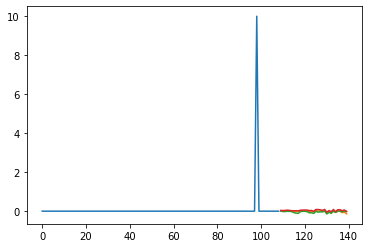

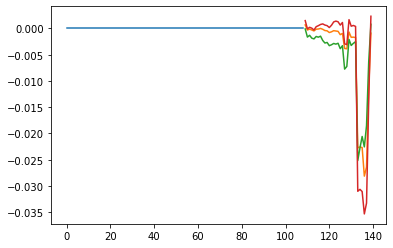

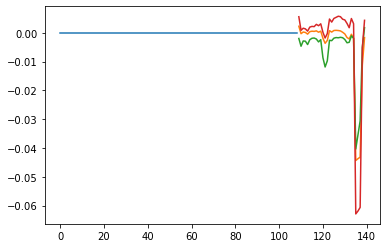

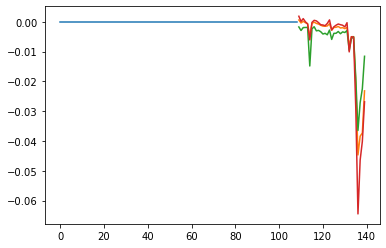

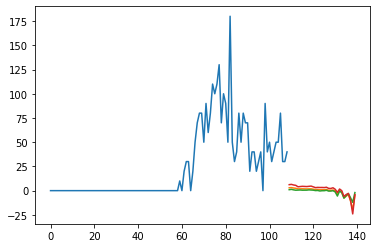

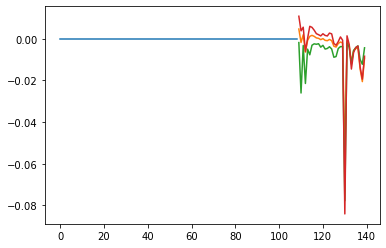

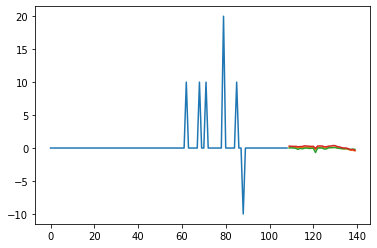

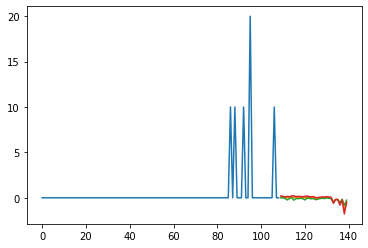

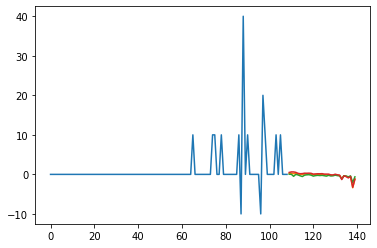

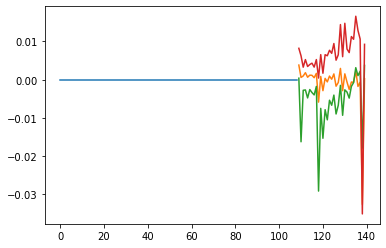

In [54]:
for i in np.random.randint(0, len(cases),10):
    plot_results(fatalities[i], submission_mean_fatalities[i], submission_max_fatalities[i], submission_min_fatalities[i])